# Scikit-rt: python toolkit for analysis of radiotherapy data

Code: [https://github.com/scikit-rt/scikit-rt/](https://github.com/scikit-rt/scikit-rt/)  
Documentation: [https://scikit-rt.github.io/scikit-rt/](https://scikit-rt.github.io/scikit-rt/)  

Developers: K. Harrison, H. Pullen  
Early adopters and testers: A. Constantinou, J.P.T. Salvesen, C. Welsh  
Development supported by Cancer Research UK RadNet Cambridge (C17918/A28870)

## Installation

1. User installation

Installation tested for [Python 3.8](https://www.python.org/downloads/release/python-380/).

```
pip install scikit-rt
```

2. Developer installation

Installation requires [git](https://git-scm.com/) and [Conda](https://docs.conda.io/projects/conda/en/latest/).

```
git clone https://github.com/scikit-rt/scikit-rt
cd scikit-rt
conda env create --file environment.yml
```

Following installation, Scikit-rt environment can be activated and deactivated:
```
# Activate envrionment
conda activate skrt

# Deactivate environment
conda deactivate skrt
```

## Using Scikit-rt

Scikit-rt can be used in scripts to be run from the command line, or in [https://jupyter.org/](Jupyter), where interactive features are enabled for image viewing.  The Scikit-rt installation includes both [Jupyter Notebook](https://jupyter-notebook.readthedocs.io/en/latest/) and [JupyterLab](https://github.com/jupyterlab/jupyterlab).

Scikit-rt is able to read [DICOM](https://www.dicomstandard.org/current) data (images, RTDOSE, RTSTRUCT, RTPLAN) and [NIfTI](https://nifti.nimh.nih.gov/) (images, dose images, ROIs represented as masks), and to convert between them.

## Setup

In [1]:
# Import relevant modules and classes.
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from skrt import Dose, Patient, set_viewer_options
from skrt.core import get_data_by_filename
from voxtox.roi_names import head_and_neck_plan

# Set scikit-rt viewer options.
options = set_viewer_options()
# Make display interactive ("no_ui": False) or non-interactive ("no_ui": True).
options["no_ui"] = False
# Include the interface for interactive zooming.
options["zoom_ui"] = not options["no_ui"]
# Use centre left of legend as reference point for fixing its location.
options["legend_loc"] = "center left"
# Set coordinates of legend reference point,
# in system where image axes extend from 0 to 1.
options["legend_bbox_to_anchor"] = (1.8, 0.5)
# Set figure size in inches.
options["figsize"] = (13, 6)
# Overlay default image annotation (slice z-coordinate), in white, at default position (top left or image).
options["annotate_slice"] = {"color": "white", "fontsize": 24}

## Data exploration

This demo has been developed using anonymised data for consented patients who participated in the [VoxTox study](https://doi.org/10.23726/cij.2017.457), supported by Cancer Research UK.  Scikit-rt has special treatment for [patient data organised in studies](https://scikit-rt.github.io/scikit-rt/README.html#patients-and-studies) according to a scheme originally devised for the VoxTox data.  In other cases, a patient's DICOM data can be read using:

```
patient = Patient("/path/to/data/directory/for/a/single/patient", unsorted_dicom=True)
```

In [2]:
# Determine paths to demo data.
paths = list(Path("demo_data").glob("*"))
# Create Patient object.
patient = Patient(paths[0])
# If notebook is to be used interactively, print out study details.
if not options["no_ui"]:
    print(patient.studies)

In [3]:
# Obtain references to selected objects.
ct = patient.studies[0].ct_images[0]
cthd = patient.studies[0].cthd_images[0]
dose = patient.studies[0].la3_doses[0]
plan = patient.studies[0].la3_plans[0]
plan.load_constraints()
ss1 = patient.studies[0].ct_structure_sets[0].filtered_copy(names=head_and_neck_plan, keep_renamed_only=True)
ss1.set_image(ct)
ss1.name = "plan"
ss2 = patient.studies[0].cthd_structure_sets[0].filtered_copy(to_keep=ss1.get_roi_names())
ss2.set_image(ct)
innereye_images = get_data_by_filename(patient.studies[0].innereye_images)

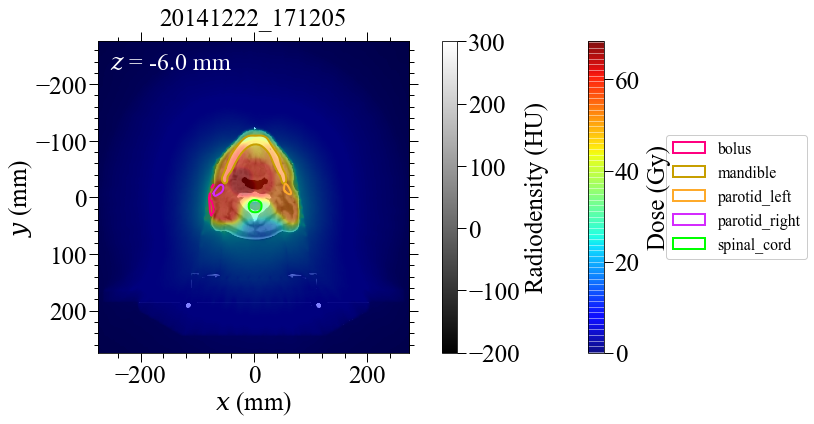

In [4]:
# Set options differently depending on whether notebook is to be used interactively.
roi_plot_type = "contour" if options["no_ui"] else "none"
dose_opacity = 0.5 if options["no_ui"] else None

# Display image and associated data.
ct.view(dose=dose, rois=ss1, roi_plot_type=roi_plot_type, legend=True,
        colorbar=2, dose_opacity=dose_opacity, **options);

## Overlap and distance metrics for comparing ROI contours

Two sets of contours have been obtained for a selection of regions of interest (ROIs).  One set is from the clinical outlining performed manually to define the treatment plan.  The other set is from auto-segmentation with the [InnerEye Deep Learning Library](https://github.com/microsoft/InnerEye-DeepLearning), trained on clinical data.  The dataset for which ROIs are compared here was not included in the training set.

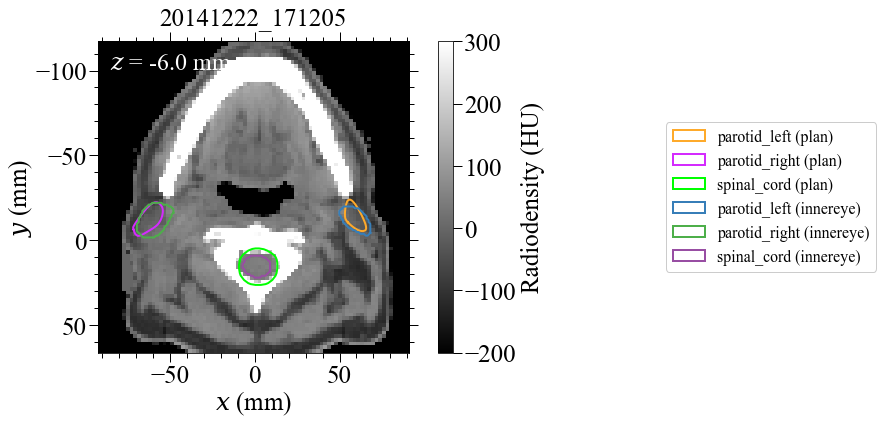

In [5]:
# Display image, and two sets of ROI contours.
# Calculate Dice scores for full ROIs, and for individual slice shown.
ct.view(rois=[ss1, ss2], compare_rois=["dice", "dice_slice"],
        legend=True, zoom=3, zoom_centre=(None, -25.5, None),
        colorbar=1, **options);

In [6]:
# Summarise results for a selection of comparison metrics.
ss1.get_comparison(ss2, units_in_header=True, decimal_places=2,
                   metrics=['dice', 'jaccard', 'centroid', 'abs_centroid', 'volume_ratio',
                            'mean_surface_distance', 'mean_signed_surface_distance',
                            'rms_signed_surface_distance', 'hausdorff_distance']
                  )

,dice,jaccard,centroid_x (mm),centroid_y (mm),centroid_z (mm),abs_centroid (mm),volume_ratio,mean_surface_distance,mean_signed_surface_distance,rms_signed_surface_distance,hausdorff_distance
parotid_left,0.85,0.74,0.52,-0.71,0.80,1.19,0.94,1.23,-0.07,1.62,6.71
parotid_right,0.79,0.66,0.79,-2.60,-2.16,3.47,0.89,1.92,0.15,2.91,11.58
spinal_cord,0.59,0.42,-0.72,10.21,-33.20,34.74,0.64,6.30,6.72,19.28,68.54


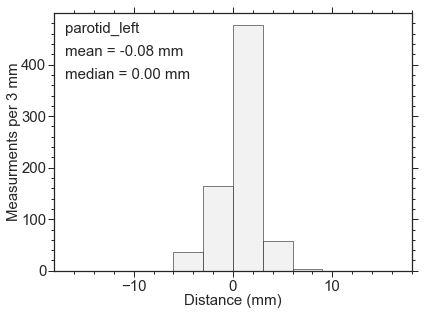

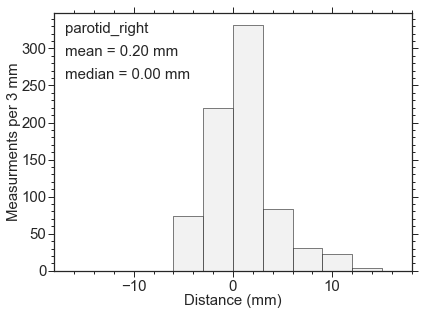

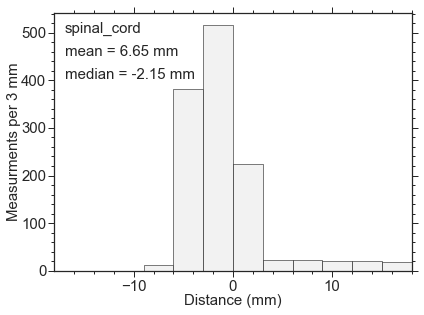

In [7]:
# Define matplotlib runtime configuration and style.
# For details of possibilities, see:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
#mpl.rcdefaults()
plt.style.use('seaborn-ticks')
mpl.rc('axes', grid=False, labelsize=15, xmargin=0)
mpl.rc('figure', figsize=(6., 4.5))
mpl.rc('grid', linestyle=(0, (1, 1)))
mpl.rc('patch', edgecolor='black', linewidth=0.5)
mpl.rc('xtick', labelsize=15, top=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick', labelsize=15, right=True)
mpl.rc('ytick.minor', visible=True)

# Plot histograms of signed surface distances.
for roi_name in sorted(ss2.get_roi_names()):
    sds = ss1[roi_name].get_surface_distances(ss2[roi_name], signed=True)
    fig, ax = plt.subplots(1, 1, tight_layout=True)

    ax.hist(x=sds, bins=12, range=(-18, 18), color=(3*[0.95]), edgecolor='black')
    ax.set(xlabel='Distance (mm)', ylabel='Measurments per 3 mm')
    for idx, text in enumerate([roi_name, f'mean = {np.mean(sds):0.2f} mm',
                                f'median = {np.quantile(sds, 0.5):0.2f} mm']):
        ax.annotate(text=text, xy=(0.15, (0.87 - idx * 0.07)), xycoords='figure fraction', size=15)

## Dose metrics for comparing ROIs

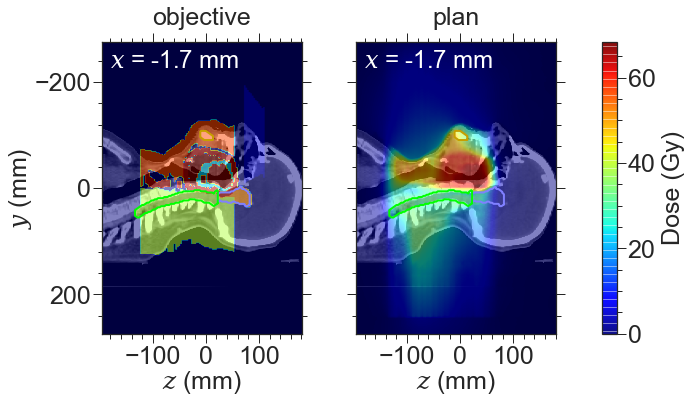

In [8]:
# Reset scikit-rt viewer options after matplotlib interlude.
set_viewer_options()

# Display dose objectives, and plan derived from this.
# Temporarily set non-null title.
options["title"] = ["objective", "plan"]
ct.view(init_view="z-y", images=ct, rois=[ss1, ss1],
        dose=[plan.get_dose_objective(), dose], colorbar=-2, **options)
options["title"] = ""

In [9]:
# Calculate dose quantiles for objectives and plan.
format = ".1f"
quantiles = [0.50, 0.90]

for quantile in quantiles:
    print(f"\n{quantile:{format}} quantiles")
    for ss in [ss1, ss2]:
        print()
        for roi_name in ss2.get_roi_names():
            roi = ss[roi_name]
            print(f"{ss.name}_{roi.name}: objective: "
                  f"{plan.get_dose_objective().get_dose_quantile(roi, quantile):{format}} Gy; "
                  f"plan: {dose.get_dose_quantile(roi, quantile):{format}} Gy")


0.5 quantiles

plan_parotid_left: objective: 15.0 Gy; plan: 36.8 Gy
plan_parotid_right: objective: 20.0 Gy; plan: 58.1 Gy
plan_spinal_cord: objective: 34.0 Gy; plan: 30.1 Gy

innereye_parotid_left: objective: 15.0 Gy; plan: 33.4 Gy
innereye_parotid_right: objective: 60.0 Gy; plan: 59.1 Gy
innereye_spinal_cord: objective: 34.0 Gy; plan: 29.3 Gy

0.9 quantiles

plan_parotid_left: objective: 54.0 Gy; plan: 53.8 Gy
plan_parotid_right: objective: 60.0 Gy; plan: 60.3 Gy
plan_spinal_cord: objective: 34.0 Gy; plan: 32.6 Gy

innereye_parotid_left: objective: 54.0 Gy; plan: 53.3 Gy
innereye_parotid_right: objective: 60.0 Gy; plan: 60.4 Gy
innereye_spinal_cord: objective: 34.0 Gy; plan: 32.2 Gy


## Check what's been done by InnerEye

As well as a binary mask for each ROI segmented, results from InnerEye include posterior probabilities and Shannon entroy.  Scikit-rt doesn't have any specific handling of these.  Howver they are in NIfTI format, and with little effort can be overlain on CT images.

In [10]:
# Obtain dictionary of InnerEye posterior probabilities and Shannon entropy.
# Cast to doses to allow overlay.
for key in innereye_images:
    image = innereye_images[key]
    innereye_images[key] = Dose(image.get_data(standardise=True) / 255,
                                affine=image.get_affine(standardise=True))
    if "posterior" in key:
        innereye_images[key]._default_colorbar_label = "Probability"
    elif "uncertainty" in key:
        innereye_images[key]._default_colorbar_label = "Shannon entropy"

# Print keys so as to know what can be plotted.
print(innereye_images.keys())

dict_keys(['001_posterior_background', '001_posterior_parotid_left', '001_posterior_parotid_right', '001_posterior_spinal_cord', '001_uncertainty'])


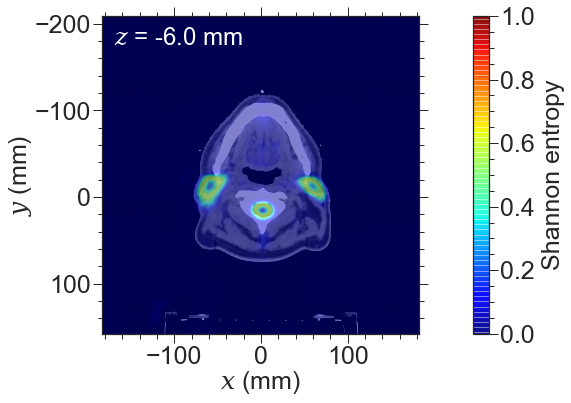

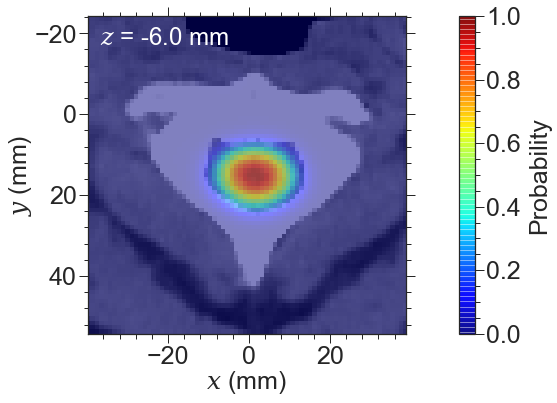

In [11]:
# Overlay Shannon entropy on CT image.
cthd.view(dose=innereye_images['001_uncertainty'],
               rois=None, dose_kwargs={"vmin": 0, "vmax": 1}, legend=True,
               zoom=1.5, zoom_centre=(None, -25.5, None), colorbar=-2,
               **options);

# Overlay posterior probability on CT image.
cthd.view(dose=innereye_images['001_posterior_spinal_cord'],
               rois=None, dose_kwargs={"vmin": 0, "vmax": 1}, legend=True,
               zoom=7.0, zoom_centre=(None, 15.0, None), colorbar=-2,
               **options);

## Additional information about Scikit-rt

Additional functionality provided by Scikit-rt includes:

- generation of synthetic images and structure sets, based around geometrical shapes;
- creation of consensus contours (STAPLE, majority vote);
- image registration with [Elastix](https://elastix.lumc.nl/) (installed separately);
- parallel processing of large datasets, using [ganga-skrt](https://github.com/kh296/ganga-skrt) extension on a cluster of machines.

Each time Scikit-rt is updated, a set of tests (currently numbering just under 300) is run automatically on GitHub for Linux, MacOs and Windows.

Scikit-rt code documentation is recreated from docstrings at each update.

## Scikit-rt: python toolkit for analysis of radiotherapy data

Code: [https://github.com/scikit-rt/scikit-rt/](https://github.com/scikit-rt/scikit-rt/)  
Documentation: [https://scikit-rt.github.io/scikit-rt/](https://scikit-rt.github.io/scikit-rt/)  

Developers: K. Harrison, H. Pullen  
Early adopters and testers: A. Constantinou, J.P.T. Salvesen, C. Welsh  
Development supported by Cancer Research UK RadNet Cambridge (C17918/A28870)